In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
print('CUDA available:', torch.cuda.is_available())

2.1.2.post303
CUDA available: True


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from tqdm import tqdm

import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Identity, Dropout, Softmax
from torch_geometric.nn import EdgeConv, GCNConv, GraphConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx

from torch.utils.tensorboard import SummaryWriter

/home/karthik/anaconda3/lib/python3.10/site-packages/torch_geometric/typing.py:73: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/karthik/anaconda3/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/karthik/anaconda3/lib/python3.10/site-packages/torch_geometric/typing.py:111: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/karthik/anaconda3/lib/python3.10/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [3]:
data = np.load('./task2Datasets/QG_jets_withbc_1.npz')
print(data)

print(data.files)
X = data['X']
y = data['y']
print(X.shape, y.shape, sep='\n')

['X', 'y']
(100000, 137, 4)
(100000,)


## Utility functions

In [4]:
# arr is a 2d array
# function returns a 1d array consisting each row's (jet's) multiplicity

def get_multiplicities(arr):
    nonzeros = (arr != 0).astype(int)
    return np.sum(nonzeros, axis=1)

def plot_jets(jet_index, jet_etas, jet_phis):
    if jet_index < 0:
        raise Excetion('Error, Jet index should be between 0 and 99999')

    eta = X[jet_index, :, 1] 
    phi = X[jet_index, :, 2] 
    
    # remove zero paddings,
    nonzero_mask = X[jet_index, :, 1] != 0
    eta = X[jet_index, nonzero_mask, 1] - jet_etas[jet_index]
    phi = X[jet_index, nonzero_mask, 2] - jet_phis[jet_index]

    # check multiplicities
    print(eta.shape, phi.shape)
    print(get_multiplicities(X[:, :, 1])[jet_index])

    # plot
    plt.figure(figsize=(8, 3))

    plt.subplot(1, 2, 1)
    plt.hist2d(eta, phi, cmap='viridis', range=[[-2, 2], [-2, 2]], bins =100)
    
    plt.subplot(1, 2, 2)
    plt.scatter(eta, phi)
    ax = plt.gca()
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    
    plt.show()

## Feature Engineering

In [5]:
print(X.shape)

(100000, 137, 4)


In [6]:
# checking bounds of dataset
print(f'transverse momentum bounds: min={np.min(X[:,:, 0])}, max={np.max(X[:,:, 0])}, mean={np.mean(X[:,:, 0])}')
print(f'pseudo-rapidity bounds: min={np.min(X[:,:, 1])}, max={np.max(X[:,:, 1])}, mean={np.mean(X[:,:, 1])}')
print(f'azimuthal angle bounds: min={np.min(X[:,:, 2])}, max={np.max(X[:,:, 2])}, mean={np.mean(X[:,:, 2])}')

transverse momentum bounds: min=0.0, max=548.415807621, mean=3.8235925586685777
pseudo-rapidity bounds: min=-2.10354644796, max=2.1094042875, mean=0.0017309813976636966
azimuthal angle bounds: min=-0.462937251085, max=6.75555673857, mean=0.9957003344113187


The bounds indicate that they have to be normalized  

After getting the jet pT, rapidiy and azimuthal angles, we plot the jets to see if we are getting the correct jet centered images

In [7]:
# creating jet-centered features - step-1

# derive jet pT, rapidity and azimuthal angles

# assuming jet momentum is the sum of the momenta of all particles
jet_pTs = np.sum(X[:, :, 0], axis=1)
print(jet_pTs.shape)
print(jet_pTs.min(), jet_pTs.max(), jet_pTs.mean())

# mean rapidity of all particles is taken as jet rapididty
jet_etas = np.sum(X[:, :, 1], axis=1) / get_multiplicities(X[:, :, 1])
print(jet_etas.shape)
print(jet_etas.min(), jet_etas.max(), jet_etas.mean())

# mean of azimuthal angles of all particles is jet azimuthal angle
jet_phis = np.sum(X[:, :, 2], axis=1) / get_multiplicities(X[:, :, 2])
print(jet_phis.shape)
print(jet_phis.min(), jet_phis.max(), jet_phis.mean())

(100000,)
500.0463140266235 561.457792111489 523.8321805375957
(100000,)
-1.7755351646578785 1.7951616238948889 0.005324459752633116
(100000,)
-0.09567027409355122 6.526761820212942 3.1443253285741286


(67,) (67,)
67


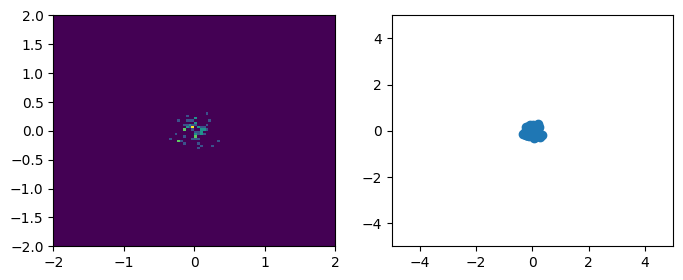

In [8]:
# run this function below with a random jet index to see its jet structure plotted on eta-phi plane
plot_jets(6950, jet_etas, jet_phis)

The images are centered around the origin for all the jets that are checked, so we can proceed creating derived features

In [9]:
# step 2. Create arrays with respective operations

# take only non-padded elements
particle_mask = (X[:, :, 0] != 0).astype(int)
padding_mask = (X[:, :, 0] == 0).astype(int)

# delta eta, delta phi features
rel_eta_arr = X[:, :, 1] - (particle_mask * jet_etas[:, None])
rel_phi_arr = X[:, :, 2] - (particle_mask * jet_phis[:, None])


# log(pT) feature
log_pT_arr = X[:, :, 0] + (padding_mask * np.ones(X[:, :, 0].shape))
log_pT_arr = np.log(log_pT_arr)

# log(pT/pT_jet) feature
pT_div_pTjet = X[:, :, 0] / (jet_pTs[:, None])
log_pT_pTjet_arr = pT_div_pTjet + (padding_mask * np.ones(X[:, :, 0].shape))
log_pT_pTjet_arr = np.log(log_pT_pTjet_arr)

# delta R feature
delta_r_arr = np.sqrt(np.square(rel_eta_arr) + np.square(rel_phi_arr))

The last feature array is left out, Now extracting its details,

In [10]:
pdgid = np.abs(X[:, :, 3])

pdgid_list = np.ravel(pdgid)
print(np.unique(pdgid_list))

[   0.   11.   13.   22.  130.  211.  321. 2112. 2212.]


This output array tells us the pdgid's of all particles encountered in the jets,  
so that we can create an exhaustive classification of particles as features

output: [   0.   11.   13.   22.  130.  211.  321. 2112. 2212.]

Note: This output is consistent across whole dataset, ie., across 2M jets

0 -> no data  
11 -> electron (charge = -1)  
13 -> muon (charge = -1)  
22 -> photon (charge = 0)  
130 -> $K^{0}_{L}$ (charge = 0)  
211 -> $\pi^{+} Meson$ (charge = +1)
321 -> $K^{+} Meson$ (charge = +1)  
2112 -> n (charge = 0) in hadron scheme  
2212 -> p (charge = +1)

We use this data to create additional feature arrays

In [11]:
# creating new 2d arrays binning particles into respective categories

is_electron_arr = (pdgid == 11).astype(int) # e- is the only particle with pdgid 11
is_muon_arr = (pdgid == 13).astype(int) # muon is the only particle with pdgid 13
is_photon_arr = (pdgid == 22).astype(int) # photon is the only particle with pdgid 22
is_charged_hadron_arr = ((pdgid == 211).astype(int)) + ((pdgid == 2212).astype(int)) # pi meson and protons are charged hadrons
is_neutral_hadron_arr = ((pdgid == 130).astype(int)) + ((pdgid == 2112).astype(int)) # pi meson and protons are charged hadrons

charge_arr = (is_electron_arr*-1) + (is_muon_arr*-1) + (is_charged_hadron_arr*+1)


# now create the data array with all created feature arrays
Xnew = np.dstack([rel_eta_arr, rel_phi_arr, log_pT_arr, log_pT_pTjet_arr, delta_r_arr, 
                 charge_arr, is_electron_arr, is_muon_arr, is_charged_hadron_arr, is_neutral_hadron_arr, is_photon_arr])

print(Xnew.shape)

(100000, 137, 11)


In [12]:
df = pd.DataFrame(Xnew[:,:,0])
df

# save this curated dataset into numpy file
np.save('./task2Datasets/curated_data', Xnew)
np.save('./task2Datasets/labels', y)

TODO Describe the feature set

## Edge-Conv Model

In [13]:
# generate edge list of k-nearest neighbors of a node using given coordinates

def knn_particle_graph(positions, k):
  # Calculate pairwise distances between nodes
  n_nodes = positions.shape[0]
  distance_matrix = np.linalg.norm(positions[:, None] - positions[None, :], axis=2)

  # Extract top k nearest neighbors for each node (excluding itself)
  edge_list = []
  for i in range(n_nodes):
    # Sort distances in ascending order and get indices
    sorted_indices = np.argsort(distance_matrix[i])
    # Select top k neighbors (excluding itself)
    neighbors = sorted_indices[1: k + 1]
    # Create edges between the node and its neighbors
    for neighbor in neighbors:
      edge_list.append((i, neighbor))

  return edge_list

In [14]:
import networkx as nx

# function to visualize jet data as graphs
def visualize_jet_graph(jet_index):
    mask = Xnew[jet_index, :, 0] != 0
    pos = Xnew[jet_index, mask, 0:2]
    node_indices = list(range(len(pos)))
    edges = knn_particle_graph(pos, 7)
    
    G = nx.Graph()
    
    node_positions = {}
    
    for i in node_indices:
        node_positions.update({i:pos[i]})
    
    G.add_nodes_from(node_positions.keys())
    nx.set_node_attributes(G, node_positions, 'pos')
    G.add_edges_from(edges)
    
    # visualize
    plot_pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, plot_pos, with_labels=True, node_size=500, node_color='skyblue', font_size=12)
    nx.draw_networkx_edges(G, plot_pos, edge_color='gray')
    plt.show()

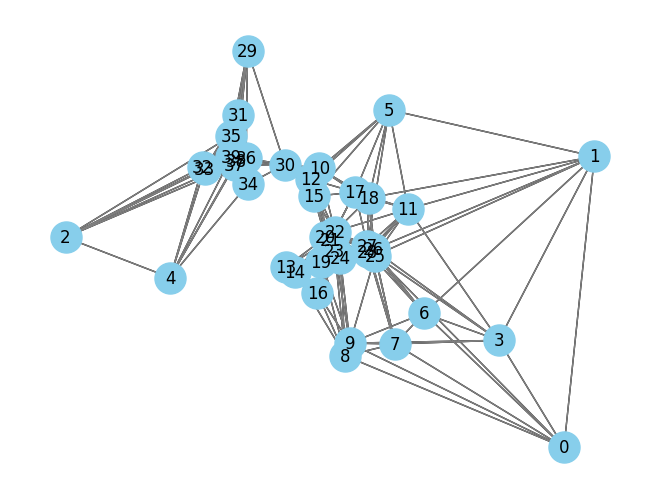

In [15]:
# sample graph representation for a jet indexed 25
visualize_jet_graph(15000)

## Dataloading into Pytorch

In [16]:
from torch_geometric.data import Dataset
from torch_geometric.data import Data

class JetGraphDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None, pre_filter=None):
        # root (where dataset is stored) -> raw_dir = we put in original dataset file
        #                                -> processed_dir = pytorch fills up intermediate/processed datasets

        self.test = test
        self.filename = filename
        super(JetGraphDataset, self).__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        # file name of dataset, should return a string
        # if pytorch finds files with this name, no download will be triggered
        return self.filename

    @property
    def processed_file_names(self):
        # names of files pytorch should give to processed datafiles
        # if these files are found, process() function will not be triggered
        if self.test:
            return ['data_test.pt']
        else:
            return ['data.pt']

    def download(self):
        pass

    def process(self):
        # create the graph and pass it to the model as data obj
        self.data = np.load(self.raw_paths[0])
        labels = np.load('./task2Datasets/labels.npy')
        
        for jet_index in tqdm(range(self.data.shape[0])):
            k = 7    
            # constuct graph for each jet
            mask = self.data[jet_index, :, 0] != 0
            pos = self.data[jet_index, mask, 0:2]
            node_indices = list(range(len(pos)))
            edges = knn_particle_graph(pos, k)

            # create the graph object in networkx
            G = nx.Graph()
            node_positions = {}
            for i in node_indices:
                node_positions.update({i:pos[i]})
            G.add_nodes_from(node_positions.keys())
            nx.set_node_attributes(G, node_positions, 'pos')
            G.add_edges_from(edges)

            
            # extract required data from graph object
            node_features = torch.tensor(self.data[jet_index, mask, :], dtype=torch.float)
            
            edge_index_no_duplicates = G.edges()
            edge_indices = []
            for edge in edge_index_no_duplicates:
                i = edge[0]
                j = edge[1]
                edge_indices += [[i, j], [j, i]]
            edge_indices = torch.tensor(edge_indices)
            edge_indices = edge_indices.t().to(torch.long).view(2, -1)
            
            edge_features = torch.tensor(self._get_edge_features(edges, pos, jet_index), dtype=torch.float)
            
            label = torch.tensor(np.asarray([labels[jet_index]]), dtype=torch.int64)
            
            data = Data(x = node_features,
                        edge_index = edge_indices,
                        edge_attr = edge_features,
                        y = label,
                        jet_index = torch.tensor(jet_index, dtype=torch.int64))

            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{jet_index}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{jet_index}.pt'))

    def _get_edge_features(self, edge_list, pos, jet_index):
        edge_lengths = []
        same_particle = []
        for p_id1, p_id2 in edge_list:
            edge_length = np.sqrt((pos[p_id1, 0]-pos[p_id2, 0])**2 + (pos[p_id1, 1]-pos[p_id2, 1])**2)
            edge_lengths.append(edge_length)

            if all(self.data[jet_index, p_id1, 6:11] == self.data[jet_index, p_id2, 6:11]):
                same_particle.append(1)
            else:
                same_particle.append(0)

        return np.vstack([edge_lengths, same_particle]).T
        

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))   
        return data

In [17]:
dataset = JetGraphDataset(root='./task2Datasets/', filename='curated_data.npy')

# Train/test split (80-20)
train_share = int(len(dataset) * 0.8)

train_dataset = dataset[:train_share]
test_dataset = dataset[train_share:]

Processing...
100%|██████████████████████████████████| 100000/100000 [02:33<00:00, 650.00it/s]
Done!


## Model - 1

### Definition

In [18]:
class EdgeConvNetwork1(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.hidden_channels2 = 2 * hidden_channels
        self.hidden_channels3 = 4 * hidden_channels
        
        # Initialize MLPs used by EdgeConv layers
        self.mlp1 = Sequential(Linear(2 * dataset.num_node_features, hidden_channels),
                              BatchNorm1d(hidden_channels),
                              ReLU(),
                              Linear(hidden_channels, hidden_channels),
                              BatchNorm1d(hidden_channels),
                              ReLU(),
                              Linear(hidden_channels, hidden_channels),
                              BatchNorm1d(hidden_channels),
                              ReLU(),
                              )
        self.mlp2 = Sequential(Linear(2* hidden_channels, self.hidden_channels2),
                              BatchNorm1d(self.hidden_channels2),
                              ReLU(),
                              Linear(self.hidden_channels2, self.hidden_channels2),
                              BatchNorm1d(self.hidden_channels2),
                              ReLU(),
                              Linear(self.hidden_channels2, self.hidden_channels2),
                              BatchNorm1d(self.hidden_channels2),
                              ReLU(),
                              )

        self.conv1 = EdgeConv(self.mlp1, aggr='mean')
        self.conv2 = EdgeConv(self.mlp2, aggr='mean')

        # Shortcut connections
        self.shortcut1 = Linear(dataset.num_node_features, hidden_channels)
        self.shortcut2 = Linear(hidden_channels, self.hidden_channels2)

        # Fully connected layer with dropout
        self.fc1 = Sequential(
            Linear(in_features=self.hidden_channels2, out_features=self.hidden_channels3),
            ReLU(),
            Dropout(p=0.1)
        )
        # second fully connected layer
        self.fc2 = Sequential(
            Linear(in_features=self.hidden_channels3, out_features=2),
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # 1st edge convolution block
        out = self.conv1(x, edge_index)
        out = out + self.shortcut1(x)
        out = F.relu(out)
        out1 = out.detach().clone()
        # 2nd edge convolution block - uses the learned feature vectors as inputs
        out = self.conv2(out, edge_index)
        out = out + self.shortcut2(out1)
        out = F.relu(out)
        # global average pooling
        out = global_mean_pool(out, batch)
        # fully-connected-1
        out = self.fc1(out)
        # fully-connected-2
        out = self.fc2(out)

        out = F.softmax(out, dim=0)

        return out

In [19]:
# instantiate model and print summary

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = EdgeConvNetwork1(64)
print(model)

print('Num parameters: ', count_parameters(model))

EdgeConvNetwork1(
  (mlp1): Sequential(
    (0): Linear(in_features=22, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (mlp2): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, mome

### Training and Evaluation function definitions

In [20]:
def train(model, loss_fn, device, data_loader, optimizer):
    """ Performs an epoch of model training.

    Parameters:
    model (nn.Module): Model to be trained.
    loss_fn (nn.Module): Loss function for training.
    device (torch.Device): Device used for training.
    data_loader (torch.utils.data.DataLoader): Data loader containing all batches.
    optimizer (torch.optim.Optimizer): Optimizer used to update model.

    Returns:
    float: Total loss for epoch.
    """
    model.train()
    loss = 0

    for batch in tqdm(data_loader):
        batch = batch.to(device)

        optimizer.zero_grad()
        out = model(batch)

        loss = loss_fn(out, batch.y)

        loss.backward()
        optimizer.step()

    return loss.item()

def eval(model, device, loader):
    """ Calculate accuracy for all examples in a DataLoader.

    Parameters:
    model (nn.Module): Model to be evaluated.
    device (torch.Device): Device used for training.
    loader (torch.utils.data.DataLoader): DataLoader containing examples to test.
    """
    model.eval()
    cor = 0
    tot = 0

    for batch in loader:
        batch = batch.to(device)

        with torch.no_grad():
            pred = torch.argmax(model(batch), 1)

        y = batch.y
        cor += (pred == y).sum()
        tot += pred.shape[0]

    return cor / tot

### Training and Model Evaulation

100%|█████████████████████████████████████████| 625/625 [00:28<00:00, 21.65it/s]


Epoch: 01, LR: 1.06E-03, Loss: 0.6865, Train: 76.78%, Test: 76.71%


100%|█████████████████████████████████████████| 625/625 [00:28<00:00, 21.61it/s]


Epoch: 02, LR: 1.63E-03, Loss: 0.6863, Train: 77.43%, Test: 77.27%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.53it/s]


Epoch: 03, LR: 2.19E-03, Loss: 0.6859, Train: 77.71%, Test: 77.61%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.49it/s]


Epoch: 04, LR: 2.75E-03, Loss: 0.6856, Train: 77.99%, Test: 77.90%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.50it/s]


Epoch: 05, LR: 3.31E-03, Loss: 0.6868, Train: 77.50%, Test: 77.31%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.48it/s]


Epoch: 06, LR: 3.88E-03, Loss: 0.6857, Train: 78.16%, Test: 78.27%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.49it/s]


Epoch: 07, LR: 4.44E-03, Loss: 0.6861, Train: 77.80%, Test: 77.88%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.45it/s]


Epoch: 08, LR: 5.00E-03, Loss: 0.6859, Train: 77.85%, Test: 77.78%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.45it/s]


Epoch: 09, LR: 4.44E-03, Loss: 0.6860, Train: 78.04%, Test: 78.07%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.44it/s]


Epoch: 10, LR: 3.87E-03, Loss: 0.6864, Train: 77.96%, Test: 78.01%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.45it/s]


Epoch: 11, LR: 3.31E-03, Loss: 0.6856, Train: 78.00%, Test: 77.97%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.45it/s]


Epoch: 12, LR: 2.75E-03, Loss: 0.6857, Train: 77.63%, Test: 77.44%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.44it/s]


Epoch: 13, LR: 2.19E-03, Loss: 0.6856, Train: 78.06%, Test: 77.87%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.43it/s]


Epoch: 14, LR: 1.62E-03, Loss: 0.6872, Train: 77.93%, Test: 77.69%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.45it/s]


Epoch: 15, LR: 1.06E-03, Loss: 0.6858, Train: 77.56%, Test: 77.42%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.44it/s]


Epoch: 16, LR: 5.00E-04, Loss: 0.6859, Train: 77.83%, Test: 77.65%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.43it/s]


Epoch: 17, LR: 1.00E-04, Loss: 0.6864, Train: 77.86%, Test: 77.73%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.43it/s]


Epoch: 18, LR: 2.00E-05, Loss: 0.6865, Train: 78.03%, Test: 78.17%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.42it/s]


Epoch: 19, LR: 4.00E-06, Loss: 0.6858, Train: 78.54%, Test: 78.53%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.40it/s]


Epoch: 20, LR: 8.00E-07, Loss: 0.6857, Train: 77.98%, Test: 77.89%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.37it/s]


Epoch: 21, LR: 1.60E-07, Loss: 0.6863, Train: 78.33%, Test: 78.40%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.41it/s]


Epoch: 22, LR: 3.20E-08, Loss: 0.6863, Train: 77.97%, Test: 77.98%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.40it/s]


Epoch: 23, LR: 6.40E-09, Loss: 0.6856, Train: 78.62%, Test: 78.40%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.40it/s]


Epoch: 24, LR: 1.28E-09, Loss: 0.6857, Train: 77.30%, Test: 77.03%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.40it/s]


Epoch: 25, LR: 2.56E-10, Loss: 0.6857, Train: 76.76%, Test: 76.38%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.43it/s]


Epoch: 26, LR: 5.12E-11, Loss: 0.6858, Train: 77.71%, Test: 77.58%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.43it/s]


Epoch: 27, LR: 1.02E-11, Loss: 0.6857, Train: 77.18%, Test: 76.83%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.34it/s]


Epoch: 28, LR: 2.05E-12, Loss: 0.6857, Train: 78.16%, Test: 77.97%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.42it/s]


Epoch: 29, LR: 4.10E-13, Loss: 0.6872, Train: 77.11%, Test: 76.80%


100%|█████████████████████████████████████████| 625/625 [00:29<00:00, 21.41it/s]


Epoch: 30, LR: 8.19E-14, Loss: 0.6857, Train: 77.26%, Test: 77.06%


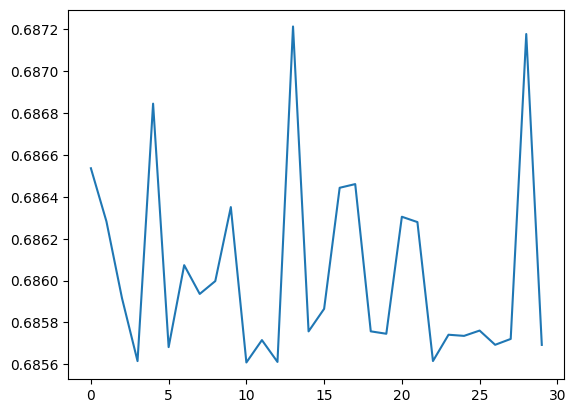

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EdgeConvNetwork1(128).to(device)


optimizer1 = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.0001)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

loss_fn = torch.nn.CrossEntropyLoss()
losses = []

for epoch in range(0, 30):
    # variable learning rates
    if epoch < 8:
        l_r = 0.0005 + ((0.005-0.0005) * (epoch+1) / 8)
    if (epoch >= 8) and (epoch < 16): 
        l_r = 0.005 + ((0.0005-0.005) * (epoch-7) / 8)
    if epoch >= 16:
        l_r = 0.0005/(5**(epoch-15))

    optimizer = torch.optim.AdamW(model.parameters(), lr=l_r, weight_decay=0.0001)
                     
    loss = train(model, loss_fn, device, train_loader, optimizer1)
    train_result = eval(model, device, train_loader)
    test_result = eval(model, device, test_loader)
    
    losses.append(loss)
    
    print(f'Epoch: {epoch + 1:02d}, '
          f'LR: {l_r:.2E}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_result:.2f}%, '
          f'Test: {100 * test_result:.2f}%')

plt.plot(losses)
plt.show()

## Model 2

### Definition

In [24]:
class EdgeConvNetwork2(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.hidden_channels2 = 2 * hidden_channels
        self.hidden_channels3 = 4 * hidden_channels
        
        # Initialize MLPs used by EdgeConv layers
        self.mlp1 = Sequential(Linear(2 * dataset.num_node_features, hidden_channels),
                              BatchNorm1d(hidden_channels),
                              ReLU(),
                              Linear(hidden_channels, hidden_channels),
                              BatchNorm1d(hidden_channels),
                              ReLU(),
                              Linear(hidden_channels, hidden_channels),
                              BatchNorm1d(hidden_channels),
                              ReLU(),
                              )
        self.mlp2 = Sequential(Linear(2* hidden_channels, self.hidden_channels2),
                              BatchNorm1d(self.hidden_channels2),
                              ReLU(),
                              Linear(self.hidden_channels2, self.hidden_channels2),
                              BatchNorm1d(self.hidden_channels2),
                              ReLU(),
                              Linear(self.hidden_channels2, self.hidden_channels2),
                              BatchNorm1d(self.hidden_channels2),
                              ReLU(),
                              )
        self.mlp3 = Sequential(Linear(2* self.hidden_channels2, self.hidden_channels3),
                              BatchNorm1d(self.hidden_channels3),
                              ReLU(),
                              Linear(self.hidden_channels3, self.hidden_channels3),
                              BatchNorm1d(self.hidden_channels3),
                              ReLU(),
                              Linear(self.hidden_channels3, self.hidden_channels3),
                              BatchNorm1d(self.hidden_channels3),
                              ReLU(),
                              )

        self.conv1 = EdgeConv(self.mlp1, aggr='mean')
        self.conv2 = EdgeConv(self.mlp2, aggr='mean')
        self.conv3 = EdgeConv(self.mlp3, aggr='mean')

        # Shortcut connections
        self.shortcut1 = Linear(dataset.num_node_features, hidden_channels)
        self.shortcut2 = Linear(hidden_channels, self.hidden_channels2)
        self.shortcut3 = Linear(self.hidden_channels2, self.hidden_channels3)

        # Fully connected layer with dropout
        self.fc1 = Sequential(
            Linear(in_features=self.hidden_channels3, out_features=self.hidden_channels3),
            ReLU(),
            Dropout(p=0.1)
        )
        # second fully connected layer
        self.fc2 = Sequential(
            Linear(in_features=self.hidden_channels3, out_features=2),
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # 1st edge convolution block
        out = self.conv1(x, edge_index)
        out = out + self.shortcut1(x)
        out = F.relu(out)
        out1 = out.detach().clone()
        # 2nd edge convolution block - uses the learned feature vectors as inputs
        out = self.conv2(out, edge_index)
        out = out + self.shortcut2(out1)
        out = F.relu(out)
        out2 = out.detach().clone()
        # 3rd edge convolution block - uses the learned feature vectors as inputs
        out = self.conv3(out, edge_index)
        out = out + self.shortcut3(out2)
        out = F.relu(out)
        # global average pooling
        out = global_mean_pool(out, batch)
        # fully-connected-1
        out = self.fc1(out)
        # fully-connected-2
        out = self.fc2(out)

        out = F.softmax(out, dim=0)

        return out

### Instantiation and Model Summary 

In [25]:
model = EdgeConvNetwork2(128)
print(model)

print('Num parameters: ', count_parameters(model))

EdgeConvNetwork2(
  (mlp1): Sequential(
    (0): Linear(in_features=22, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (mlp2): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): BatchNorm1d(256, eps=1e-

The training and evaluation functions defined above will be suitable for this network too as only  
the network architecture has been changed

### Training and Evaluation

In [33]:
# clear gpu cache from previous training session

with torch.no_grad():
    torch.cuda.empty_cache()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:32<00:00,  6.79it/s]


Epoch: 01, Loss: 0.6930, Train: 65.29%, Test: 65.50%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.72it/s]


Epoch: 02, Loss: 0.6931, Train: 65.28%, Test: 65.56%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch: 03, Loss: 0.6930, Train: 65.17%, Test: 65.42%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch: 04, Loss: 0.6931, Train: 65.20%, Test: 65.29%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:32<00:00,  6.72it/s]


Epoch: 05, Loss: 0.6931, Train: 65.24%, Test: 65.35%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:32<00:00,  6.73it/s]


Epoch: 06, Loss: 0.6931, Train: 65.65%, Test: 65.84%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.71it/s]


Epoch: 07, Loss: 0.6931, Train: 65.32%, Test: 65.44%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.72it/s]


Epoch: 08, Loss: 0.6931, Train: 65.58%, Test: 65.79%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.71it/s]


Epoch: 09, Loss: 0.6931, Train: 65.48%, Test: 65.61%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.72it/s]


Epoch: 10, Loss: 0.6931, Train: 65.23%, Test: 65.47%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.69it/s]


Epoch: 11, Loss: 0.6931, Train: 65.61%, Test: 65.60%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.65it/s]


Epoch: 12, Loss: 0.6931, Train: 65.64%, Test: 65.72%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.66it/s]


Epoch: 13, Loss: 0.6931, Train: 65.47%, Test: 65.63%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.65it/s]


Epoch: 14, Loss: 0.6931, Train: 65.30%, Test: 65.47%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.66it/s]


Epoch: 15, Loss: 0.6931, Train: 65.50%, Test: 65.71%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.67it/s]


Epoch: 16, Loss: 0.6931, Train: 65.39%, Test: 65.62%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.67it/s]


Epoch: 17, Loss: 0.6931, Train: 65.32%, Test: 65.49%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.68it/s]


Epoch: 18, Loss: 0.6931, Train: 65.49%, Test: 65.67%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:34<00:00,  6.64it/s]


Epoch: 19, Loss: 0.6931, Train: 65.49%, Test: 65.60%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.66it/s]


Epoch: 20, Loss: 0.6931, Train: 65.52%, Test: 65.67%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.69it/s]


Epoch: 21, Loss: 0.6931, Train: 65.52%, Test: 65.63%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.68it/s]


Epoch: 22, Loss: 0.6931, Train: 65.41%, Test: 65.51%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch: 23, Loss: 0.6931, Train: 65.31%, Test: 65.60%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.69it/s]


Epoch: 24, Loss: 0.6931, Train: 65.38%, Test: 65.46%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.69it/s]


Epoch: 25, Loss: 0.6931, Train: 65.45%, Test: 65.53%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.69it/s]


Epoch: 26, Loss: 0.6931, Train: 65.38%, Test: 65.63%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.69it/s]


Epoch: 27, Loss: 0.6931, Train: 65.43%, Test: 65.61%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch: 28, Loss: 0.6931, Train: 65.40%, Test: 65.54%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch: 29, Loss: 0.6931, Train: 65.43%, Test: 65.44%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch: 30, Loss: 0.6931, Train: 65.42%, Test: 65.56%


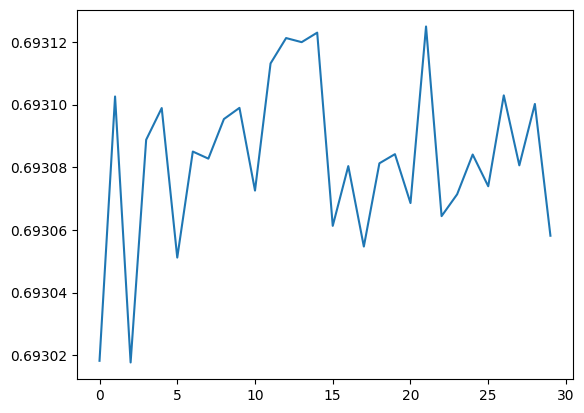

In [34]:
device2 = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model2 = EdgeConvNetwork2(128).to(device)
optimizer2 = torch.optim.AdamW(model.parameters(), lr=1e-7, weight_decay=0.0001)

train_loader2 = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader2 = DataLoader(test_dataset, batch_size=128, shuffle=False)

loss_fn2 = torch.nn.CrossEntropyLoss()
losses2 = []

for epoch in range(0, 30):
    loss2 = train(model2, loss_fn2, device2, train_loader2, optimizer2)
    train_result2 = eval(model2, device2, train_loader2)
    test_result2 = eval(model2, device2, test_loader2)
    
    losses2.append(loss2)
    
    print(f'Epoch: {epoch + 1:02d}, '
          f'Loss: {loss2:.4f}, '
          f'Train: {100 * train_result2:.2f}%, '
          f'Test: {100 * test_result2:.2f}%')

plt.plot(losses2)
plt.show()

## Performance comparison of the 2 chosen GNN architectures

1. It can be seen that despite being a simpler model, model1 achieved around 80% training and test accuracy   
   on the small dataset itself

2. The heavier model (model2) seemed to perform a little lesser than model1 on the smaller dataset but performed better
   with around 80%-83% train and test accuracies when tested with two file-d dataset (ie., 200000 jets)

3. This may be attributed to requirement of mode graphs/lesser learning-rate/more epochs to correctly identify patterns for increased no. of parameters in 2nd model. The loss curve oscillating at a fixed level might also hints at the same fact.

4. Emphasis of the task as understood is not given on the accuracies of the models but to test and explore different network configurations
   and to include as much network elements (shortcuts, variable learning rates, weight decays etc.)

5. Keeping in mind the training and compute constraints, only one dataset has been used, not all 20. This also forms a test case for the model's performance when 1/20th of actual data is given to the model.

6. Literature citing the given dataset were able to achive over 90%-95% accuracies when trained over the whole 2M jet dataset and with additional 4momentum information. Which could not be obtained from the given dataset. The given model has high chances to achieve that levels of accuracies when trained over that data as well.